# Desarrollo de Modelo de Deteccion de phising

Lucho Ago|2023 <br>
Canopee by Polo & Pan

Construir un clasificador binario que prediga si un sitio web es phishing o legítimo, basándose en 30 características por visita web.<br>
Supuestos:

Tienes el dataset en formato CSV.

Contiene 30 columnas de características y 1 columna de clase, donde la clase es 1 (phishing) o 0 (legítimo).

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib_inline as plt

import tensorflow as tf
from numpy import genfromtxt
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import (accuracy_score, confusion_matrix,f1_score,precision_score, recall_score, classification_report, confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

## Import datasets

In [2]:
df = pd.read_csv(r"phishing.csv")
df_raw = df.copy()
df.head()

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,...,-1,1,-1,-1,0,-1,1,1,1,1


In [3]:
df.shape

(11055, 31)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11055 entries, 0 to 11054
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   having_IP_Address            11055 non-null  int64
 1   URL_Length                   11055 non-null  int64
 2   Shortining_Service           11055 non-null  int64
 3   having_At_Symbol             11055 non-null  int64
 4   double_slash_redirecting     11055 non-null  int64
 5   Prefix_Suffix                11055 non-null  int64
 6   having_Sub_Domain            11055 non-null  int64
 7   SSLfinal_State               11055 non-null  int64
 8   Domain_registeration_length  11055 non-null  int64
 9   Favicon                      11055 non-null  int64
 10  port                         11055 non-null  int64
 11  HTTPS_token                  11055 non-null  int64
 12  Request_URL                  11055 non-null  int64
 13  URL_of_Anchor                11055 non-null  i

In [5]:
df.isna().sum()

having_IP_Address              0
URL_Length                     0
Shortining_Service             0
having_At_Symbol               0
double_slash_redirecting       0
Prefix_Suffix                  0
having_Sub_Domain              0
SSLfinal_State                 0
Domain_registeration_length    0
Favicon                        0
port                           0
HTTPS_token                    0
Request_URL                    0
URL_of_Anchor                  0
Links_in_tags                  0
SFH                            0
Submitting_to_email            0
Abnormal_URL                   0
Redirect                       0
on_mouseover                   0
RightClick                     0
popUpWidnow                    0
Iframe                         0
age_of_domain                  0
DNSRecord                      0
web_traffic                    0
Page_Rank                      0
Google_Index                   0
Links_pointing_to_page         0
Statistical_report             0
Result    

In [6]:
#Se eliminaron los datos duplicados, que casi el 50%
df= df.drop_duplicates()
df.shape

(5849, 31)

In [7]:
df.describe(include="all")

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
count,5849.000000,5849.000000,5849.000000,5849.000000,5849.000000,5849.000000,5849.000000,5849.000000,5849.000000,5849.000000,...,5849.000000,5849.000000,5849.000000,5849.000000,5849.000000,5849.000000,5849.000000,5849.000000,5849.000000,5849.000000
mean,0.132843,-0.616003,0.720294,0.588648,0.718242,-0.760301,0.065823,0.149085,-0.305864,0.581809,...,0.564028,0.785604,0.021371,0.475124,0.233886,-0.423833,0.661823,0.347752,0.697042,-0.032313
std,0.991222,0.777323,0.693728,0.808459,0.695852,0.649627,0.802448,0.924473,0.952157,0.813395,...,0.825826,0.618782,0.999857,0.879994,0.826010,0.905818,0.749725,0.579027,0.717091,0.999563
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,...,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,0.000000,1.000000,-1.000000
50%,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,1.000000,-1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,-1.000000,1.000000,0.000000,1.000000,-1.000000
75%,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Parte 1

In [8]:
feature=genfromtxt('phishing.csv',delimiter=',',usecols=(i for i in range(0,31)),skip_header=1)
target=genfromtxt('phishing.csv',delimiter=',',usecols=(-1),skip_header=1)
sc = StandardScaler()
sc.fit(feature)
target_label = LabelEncoder().fit_transform(target)
feature_std = sc.transform(feature)
x_train, x_test, y_train, y_test = train_test_split(feature_std, target_label, test_size=0.30, random_state=0)

In [9]:
## print stats 
precision_scores_list = []
accuracy_scores_list = []

def print_stats_metrics(y_test, y_pred):    
    print('Accuracy: %.2f' % accuracy_score(y_test,   y_pred) )
    #Accuracy: 0.84
    accuracy_scores_list.append(accuracy_score(y_test,   y_pred) )
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print ("confusion matrix")
    print(confmat)
    print (pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
    precision_scores_list.append(precision_score(y_true=y_test, y_pred=y_pred))
    print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
    print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
    print('F1-measure: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

In [10]:
print("########################Logistic Regression##############################")
clfLog = LogisticRegression()
clfLog.fit(x_train,y_train)
predictions = clfLog.predict(x_test)
print_stats_metrics(y_test, predictions)


########################Logistic Regression##############################
Accuracy: 1.00
confusion matrix
[[1498    0]
 [   0 1819]]
Predicted     0     1   All
True                       
0          1498     0  1498
1             0  1819  1819
All        1498  1819  3317
Precision: 1.000
Recall: 1.000
F1-measure: 1.000


In [11]:
########################Random Forest##############################
print("########################Random Forest##############################")
clfRandForest = RandomForestClassifier()
clfRandForest.fit(x_train,y_train)
predictions = clfRandForest.predict(x_test)
print_stats_metrics(y_test, predictions)
#######################Decision Tree#######################
print("#######################Decision Tree#######################")
clfDT = DecisionTreeRegressor()
clfDT.fit(x_train,y_train)
predictions = clfDT.predict(x_test)
print_stats_metrics(y_test, predictions)
#######################Naive Bayes#######################
print("#######################Naive Bayes#######################")
clfNB = GaussianNB()
clfNB.fit(x_train,y_train)
predictions = clfNB.predict(x_test)
print_stats_metrics(y_test, predictions)

########################Random Forest##############################
Accuracy: 1.00
confusion matrix
[[1498    0]
 [   0 1819]]
Predicted     0     1   All
True                       
0          1498     0  1498
1             0  1819  1819
All        1498  1819  3317
Precision: 1.000
Recall: 1.000
F1-measure: 1.000
#######################Decision Tree#######################
Accuracy: 1.00
confusion matrix
[[1498    0]
 [   0 1819]]
Predicted   0.0   1.0   All
True                       
0          1498     0  1498
1             0  1819  1819
All        1498  1819  3317
Precision: 1.000
Recall: 1.000
F1-measure: 1.000
#######################Naive Bayes#######################
Accuracy: 1.00
confusion matrix
[[1498    0]
 [   0 1819]]
Predicted     0     1   All
True                       
0          1498     0  1498
1             0  1819  1819
All        1498  1819  3317
Precision: 1.000
Recall: 1.000
F1-measure: 1.000


### Parte 2

In [12]:
learning_rate = 0.01
n_epochs = 5000
batch_size = 100

def convertOneHot(data):
    y_onehot=[0]*len(data)
    for i,j in enumerate(data):
        y_onehot[i]=[0]*(data.max()+1)
        y_onehot[i][j]=1
    return y_onehot

In [13]:
feature=genfromtxt('phishing.csv',delimiter=',',usecols=(i for i in range(0,31)),skip_header=1)
target=genfromtxt('phishing.csv',delimiter=',',usecols=(-1),skip_header=1)
sc = StandardScaler()
sc.fit(feature)
target_label = LabelEncoder().fit_transform(target)
target_onehot = convertOneHot(target_label)
feature_std = sc.transform(feature)
x_train, x_test, y_train_onehot, y_test_onehot = train_test_split(feature_std, target_onehot, test_size=0.30, random_state=0)
A=x_train.shape[1]
B=len(y_train_onehot[0])
print(len(y_test_onehot[0]))
print(B)
print("Begin:__________________________________")

2
2
Begin:__________________________________


In [14]:
def plot_metric_per_epoch():
    x_epochs = []
    y_epochs = [] 
    for i, val in enumerate(accuracy_scores_list):
        x_epochs.append(i)
        y_epochs.append(val)
    
    plt.scatter(x_epochs, y_epochs,s=50,c='lightgreen', marker='s', label='score')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('Score per epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [15]:
precision_scores_list = []
accuracy_scores_list = []

def print_stats_metrics(y_test, y_pred):    
    print('Accuracy: %.2f' % accuracy_score(y_test,   y_pred) )
    #Accuracy: 0.84
    accuracy_scores_list.append(accuracy_score(y_test,   y_pred) )
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print ("confusion matrix")
    print(confmat)
    print (pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
    precision_scores_list.append(precision_score(y_true=y_test, y_pred=y_pred))
    print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
    print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
    print('F1-measure: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))


In [16]:
def layer(input, weight_shape, bias_shape):
    weight_stddev = (2.0/weight_shape[0])**0.5
    w_init = tf.random_normal_initializer(stddev=weight_stddev)
    bias_init = tf.constant_initializer(value=0)
    W = tf.get_variable("W", weight_shape, initializer=w_init)
    b = tf.get_variable("b", bias_shape, initializer=bias_init)
    return tf.nn.relu(tf.matmul(input, W) + b)

In [17]:
def inference_deep_layers(x_tf, A, B):
    with tf.variable_scope("hidden_1"):
        hidden_1 = layer(x_tf, [A, 15],[15])
    with tf.variable_scope("hidden_2"):
        hidden_2 = layer(hidden_1, [15, 5],[5])
    with tf.variable_scope("output"):
        output = layer(hidden_2, [5, B], [B])
    return output

In [18]:
def loss_deep(output, y_tf):
    xentropy = tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=y_tf)
    loss = tf.reduce_mean(xentropy) 
    return loss

In [19]:
def training(cost):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_op = optimizer.minimize(cost)
    return train_op

In [20]:
def evaluate(output, y_tf):
    correct_prediction = tf.equal(tf.argmax(output,1), tf.argmax(y_tf,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    return accuracy

Epoch 1 / 10
-------------------------------------------------------------------------------
Accuracy: 0.9985
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1498
           1       1.00      1.00      1.00      1819

    accuracy                           1.00      3317
   macro avg       1.00      1.00      1.00      3317
weighted avg       1.00      1.00      1.00      3317

Confusion Matrix:
[[1493    5]
 [   0 1819]]
Epoch 2 / 10
-------------------------------------------------------------------------------
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1498
           1       1.00      1.00      1.00      1819

    accuracy                           1.00      3317
   macro avg       1.00      1.00      1.00      3317
weighted avg       1.00      1.00      1.00      3317

Confusion Matrix:
[[1498    0]
 [  

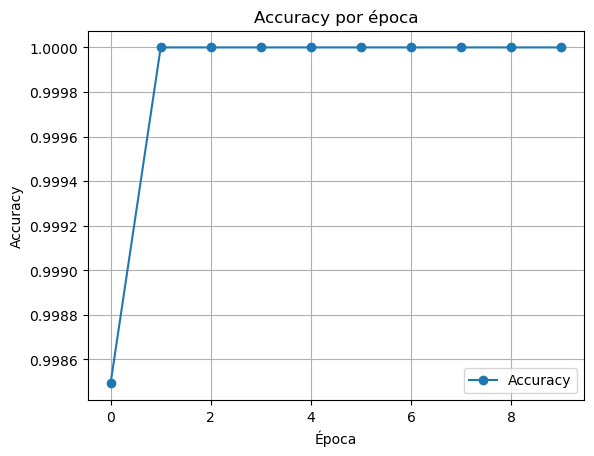

In [21]:
import matplotlib.pyplot as plt
# Convierte a numpy arrays si es necesario
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

# 2. One-hot encoding
num_classes = np.max(y_train) + 1
y_train_onehot = np.eye(num_classes)[y_train]
y_test_onehot = np.eye(num_classes)[y_test]

# 3. Hiperparámetros
A = x_train.shape[1]      
B = num_classes           
batch_size = 32
n_epochs = 10

# 4. Construcción del modelo
def build_model(input_dim, output_dim):
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(output_dim, activation='softmax')
    ])

model = build_model(A, B)

# 5. Compilación del modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

# 6. Preparar datasets con batching
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train_onehot)).shuffle(1024).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test_onehot)).batch(batch_size)

# 7. Funciones auxiliares (¡definidas antes de usarlas!)
def print_stats_metrics(y_true, y_pred):
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

def plot_metric_per_epoch(metric_values):
    plt.plot(metric_values, marker='o', label='Accuracy')
    plt.title("Accuracy por época")
    plt.xlabel("Época")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.show()

# 8. Entrenamiento por epochs y batches
accuracy_per_epoch = []

for epoch in range(n_epochs):
    print(f"Epoch {epoch + 1} / {n_epochs}")

    for x_batch, y_batch in train_dataset:
        model.train_on_batch(x_batch, y_batch)

    loss_value, acc_value = model.evaluate(test_dataset, verbose=0)
    accuracy_per_epoch.append(acc_value)

    y_pred_probs = model.predict(x_test, verbose=0)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test_onehot, axis=1)

    print("-------------------------------------------------------------------------------")
    print(f"Accuracy: {acc_value:.4f}")
    print_stats_metrics(y_true, y_pred_classes)

    if epoch == n_epochs - 1:
        plot_metric_per_epoch(accuracy_per_epoch)

In [ ]:
import arff

datos = df.values.tolist()
atributos = [(col, 'REAL') for col in df.columns[:-1]]
atributos.append(('class', ['0', '1'])) 

datos_arff = {
    'description': 'Dataset de sitios phishing',
    'relation': 'phishing',
    'attributes': atributos,
    'data': datos
}

with open('phishing_dataset.arff', 'w') as f:
    arff.dump(datos_arff, f)
